# Exercise: Parallel Monte Carlo (Threads)

**Note: You should use 8 Julia threads for this exercise. Select the Jupyter kernel `Julia (8 threads) 1.10.0`.**

In [2]:
using Base.Threads
@assert Threads.nthreads() == 8

AssertionError: AssertionError: Threads.nthreads() == 8

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

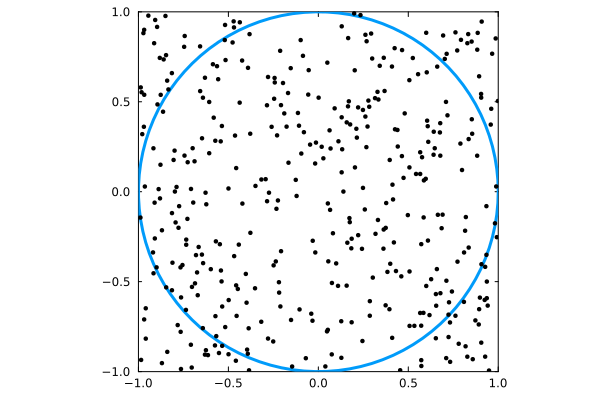

In [3]:
using Plots
using Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1, 1), ylims=(-1, 1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Basic Julia Implementation

In [4]:
function compute_pi(N)
    M = 0 # number of darts that landed in the circle
    for i in 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end
    return 4 * M / N
end

compute_pi (generic function with 1 method)

In [10]:
compute_pi(10_000_000)
@btime compute_pi(10_000_000) samples=5 evals=2

  24.287 ms (0 allocations: 0 bytes)


3.1419992

### Tasks

1. Based on `compute_pi`, write a parallel version `compute_pi_parallel(N::Int)` that divides the work into `Threads.nthreads()` parallel tasks. The final estimate for π should be the average of the estimate of each task. 
    1. **Hint:** Be aware of false sharing, that is, make sure that every tasks operates locally and only shares the local result at the end.
    2. **Hint:** If you want, implement two versions, one based on `@threads` and another using `@spawn`.

2. Benchmark and compare the serial and parallel variants.
    1. **Hint:** A reasonable value for $N$ could be `N = 10_000_000`.

In [6]:
using BenchmarkTools
using Base.Threads

In [16]:
function compute_pi_parallel(N)
    M = zeros(nthreads())
    @threads for i in 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M[threadid()] += 1
        end
    end
    return 4 * sum(M) / N
end

# function compute_pi_parallel_threads(N::Int)
#     nt = nthreads()
#     pis = zeros(nt)
#     @threads for i in 1:nt
#         pis[i] = compute_pi(ceil(Int, N / nt))
#     end
#     return sum(pis) / nt  # average
# end

@btime compute_pi_parallel(10_000_000) samples=5 evals=2

  10.970 ms (122 allocations: 12.86 KiB)


3.1410928

3. Write a function `compute_pi_multiple(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in serial** computes $\pi$ for all these values. The function should be entirely serial and based on `compute_pi`. Benchmark and compare to the previous variants.

In [17]:
some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

function compute_pi_multiple(Ns::Vector{Int})
    S = 0
    for N in Ns
        S += compute_pi(N)
    end
    return S / length(Ns)
end
@btime compute_pi_multiple(some_Ns) samples=5 evals=2

  24.287 ms (0 allocations: 0 bytes)


3.1408740833333333

4. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in parallel** computes $\pi$ for all these values. The function should still be based on the serial `compute_pi`. Benchmark and compare to the previous variants.

In [19]:
some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

function compute_pi_multiple_parallel(Ns::Vector{Int})
    pis = zeros(length(Ns))
    @threads for i in 1:length(pis)
        pis[i] = compute_pi(Ns[i])
    end
    return pis
end

@btime compute_pi_multiple_parallel($some_Ns) samples=5 evals=2

  10.925 ms (122 allocations: 12.70 KiB)


4-element Vector{Float64}:
 3.139912
 3.140722
 3.143572
 3.142042

5. Calculate $\pi$ estimates for the following $N$ values: `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.

In [20]:
# N values (nothing todo here)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)));

In [22]:
# Important: the resulting pi estimates should be stored in a variable named: pis
pis = compute_pi_multiple_parallel(Ns)

50-element Vector{Float64}:
 3.2
 3.142857142857143
 2.6
 2.962962962962963
 3.3684210526315788
 3.0
 3.5
 2.96
 3.366906474820144
 3.154639175257732
 ⋮
 3.140692666256951
 3.1415648
 3.1409912446639807
 3.1413730310357217
 3.1414251291555306
 3.141471369546757
 3.1413756302352436
 3.1417754484152027
 3.14189408

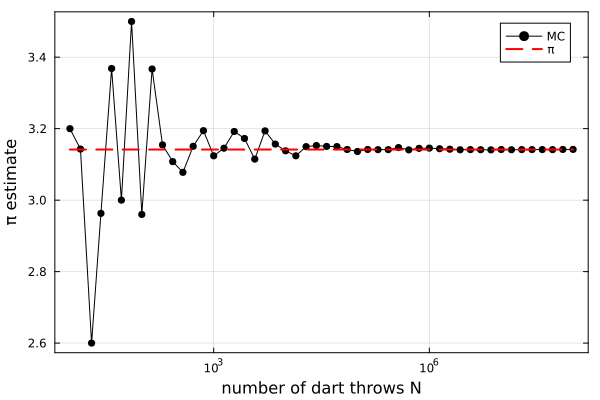

In [23]:
# Plotting (nothing todo here)
plot(Ns, pis, color=:black, marker=:circle, lw=1, label="MC", xscale=:log10, frame=:box)
plot!(x -> π, label="π", xscale=:log10, linestyle=:dash, color=:red, lw=2)
ylabel!("π estimate")
xlabel!("number of dart throws N")

6. **Bonus:** Try to write a function `compute_pi_multiple_nested_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values using nested multithreading: Both the outer computation ("for each N in Ns") as well as the inner computation ("compute pi for a given N") should be parallelized. Benchmark and compare to the previous variants.
    1. Could you have used `@threads :static` here? **Answer:** No, because it doesn't support nesting.

In [ ]:
some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

# TODO...

# @btime compute_pi_multiple_nested_parallel($some_Ns) samples=5 evals=2

# from above, for comparison
# @btime compute_pi_multiple_parallel($some_Ns) samples=5 evals=2